In [ ]:
import pandas as pd
import re

In [ ]:
# Load the dataset
df_cleaned = pd.read_csv('cleaned_data.csv')
df_cleaned

In [16]:
# Importing warnings library.
# Using this to avoid the warnings from getting displayed.
import warnings
warnings.filterwarnings('ignore')

In [17]:
# Define a function called Fake_label that takes a text input
def Fake_label(text):
    # Replace "TRUE" with '6' in the text
    a = re.sub("TRUE", '6', text)
    # Replace "mostly-true" with '5' in the text
    b = re.sub("mostly-true", '5', a)
    # Replace "half-true" with '4' in the text
    c = re.sub("half-true", '4', b)
    # Replace "barely-true" with '3' in the text
    d = re.sub("barely-true", '3', c)
    # Replace "FALSE" with '2' in the text
    e = re.sub("FALSE", '2', d)
    # Replace "full-flop" with '3' in the text
    f = re.sub("full-flop", '3', e)
    # Replace "no-flip" with '3' in the text
    g = re.sub("no-flip", '3', f)
    # Replace "half-flip" with '3' in the text
    h = re.sub("half-flip", '3', g)
    # Replace "pants-fire" with '1' in the text
    label = re.sub("pants-fire", '1', h)
    # Return the transformed text
    return label

# Convert the 'Label' column in the DataFrame df to string type
df_cleaned['Label'] = df_cleaned['Label'].astype(str)

# Apply the Fake_label function to each value in the 'Label' column and assign the result back to the 'Label' column
df_cleaned['Label'] = df_cleaned['Label'].apply(Fake_label)

## <span style="color:blue;">Decision tree</span>

In [18]:
import utils9
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
# Features (x): All columns except the 'Label' column
x = df_cleaned.drop(['Clean_News_Headline', 'Clean_Source', 'Label'], axis=1)

# Target variable (y): 'Label' column
y = df_cleaned['Label']

<span style="color:blue;">Split the data into training, validation, and testing sets. Try different proportions and justify the final choices.</span>

In [20]:
# First, split into training and the rest
dt_x_train, dt_x_temp, dt_y_train, dt_y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
 
# Then, split the rest into validation and testing
dt_x_val, dt_x_test, dt_y_val, dt_y_test = train_test_split(dt_x_temp, dt_y_temp, test_size=0.5, random_state=42)

The code splits the dataset into three subsets: training, validation, and testing sets. Initially, 80% of the data is allocated for training to facilitate effective learning of patterns by the model. The remaining 20% is divided equally, with half reserved for validation purposes, allowing for the tuning of hyperparameters and prevention of overfitting during model training. The remaining portion is designated for testing, providing an unbiased evaluation of the model's performance on unseen data, ensuring reliable estimates of its real-world effectiveness. This approach enables robust model development, tuning, and evaluation while maintaining the integrity of the dataset's assessment process.

<span style="color:blue;">Try both Gini impurity index and Entropy as a condition for splitting branches. Experiment with different values of max_depth, max_features, min_impurity_decrease, min_samples_leaf, min_samples_split, and any other hyperparameters you wish. Keep your best two (or more) models.</span>

In [21]:
# Train and evaluate the decision tree model
dtree = DecisionTreeClassifier()
dtree.fit(dt_x_train, dt_y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [22]:
# Define parameter grid
dt_param_grid = {
    # Criteria for split evaluation
    'criterion': ['gini', 'entropy'],
    # Maximum depth of the tree
    'max_depth': [None, 3, 5, 10],  
    # Maximum number of features to consider for split
    'max_features': [None, 'sqrt', 'log2'],  
    # Minimum samples required to be at a leaf node
    'min_samples_leaf': [5, 10, 15],  
    # Minimum impurity decrease required for split
    'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1, 0.2]  
}

# Initialize Decision Tree classifier
dt_classifier = DecisionTreeClassifier()

# Initialize GridSearchCV with stratified cross-validation
dt_grid_search = GridSearchCV(estimator=dt_classifier, param_grid=dt_param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Initialize a list to store the best models
best_dt_models = []

# Perform GridSearchCV
dt_grid_search.fit(dt_x_train, dt_y_train)

# Get the top two best models
dt_cv_results = dt_grid_search.cv_results_
# Sort the models based on mean test score and get the indices of the top two models
dt_top_2 = dt_cv_results['mean_test_score'].argsort()[-2:][::-1]

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:   53.6s finished


In [23]:
# Retrieve the best parameters found by the grid search
dt_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5}

In [24]:
# Print top two best models with their parameters and accuracy
for idx in dt_top_2:
    # Extract parameters and accuracy for the current model
    model_params = dt_cv_results['params'][idx]
    model_accuracy = dt_cv_results['mean_test_score'][idx]
    # Initialize Decision Tree classifier with best parameters
    best_dt_model = DecisionTreeClassifier(**model_params, random_state=42)
    # Train the best model
    best_dt_model.fit(dt_x_train, dt_y_train)
    # Store the best model in the list
    best_dt_models.append(best_dt_model)

In [25]:
# Print best parameters and best accuracy of the top model
print(f"Model 1 - Best Parameters: {dt_cv_results['params'][dt_top_2[0]]}")
print(f"Model 1 - Best Accuracy: {dt_cv_results['mean_test_score'][dt_top_2[0]]}")

Model 1 - Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5}
Model 1 - Best Accuracy: 0.2546448113255846


In [26]:
# Print best parameters and best accuracy of the second best model
print(f"Model 2 - Best Parameters: {dt_cv_results['params'][dt_top_2[1]]}")
print(f"Model 2 - Best Accuracy: {dt_cv_results['mean_test_score'][dt_top_2[1]]}")

Model 2 - Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5}
Model 2 - Best Accuracy: 0.25401753751710154


<span style="color:blue;">On your best decision tree models, use the classification_report and confusion_matrix functions in sklearn to display metrics, using training and validation (but not testing) data. Also use the display_tree method in utils.py to display each tree.</span>

In [27]:
# Function to display classification report and confusion matrix
def display_metrics(model, x, y, y_pred):
    # Classification report
    print("Classification Report:")
    print(classification_report(y, y_pred))
    # Confusion matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y, y_pred))

In [28]:
# Get predictions for best model 1 using training data
dt_y_pred_train_1 = best_dt_models[0].predict(dt_x_train)
# Get predictions for best model 1 using validation data
dt_y_pred_val_1 = best_dt_models[0].predict(dt_x_val)

In [29]:
# Display metrics for the best model 1 using training data
print("Metrics for Best Model 1 using Training Data:")
display_metrics(best_dt_models[0], dt_x_train, dt_y_train, dt_y_pred_train_1)

# Display metrics for the best model 1 using validation data
print("\nMetrics for Best Model 1 using Validation Data:")
display_metrics(best_dt_models[0], dt_x_val, dt_y_val, dt_y_pred_val_1)

Metrics for Best Model 1 using Training Data:
Classification Report:
              precision    recall  f1-score   support

           1       0.51      0.31      0.38      1126
           2       0.23      0.85      0.36      1785
           3       0.23      0.11      0.15      1461
           4       0.00      0.00      0.00      1341
           5       0.00      0.00      0.00      1417
           6       0.00      0.00      0.00       838

    accuracy                           0.25      7968
   macro avg       0.16      0.21      0.15      7968
weighted avg       0.17      0.25      0.16      7968


Confusion Matrix:
[[ 345  709   72    0    0    0]
 [ 156 1510  119    0    0    0]
 [  70 1225  166    0    0    0]
 [  49 1130  162    0    0    0]
 [  42 1245  130    0    0    0]
 [  19  747   72    0    0    0]]

Metrics for Best Model 1 using Validation Data:
Classification Report:
              precision    recall  f1-score   support

           1       0.52      0.36      0.43

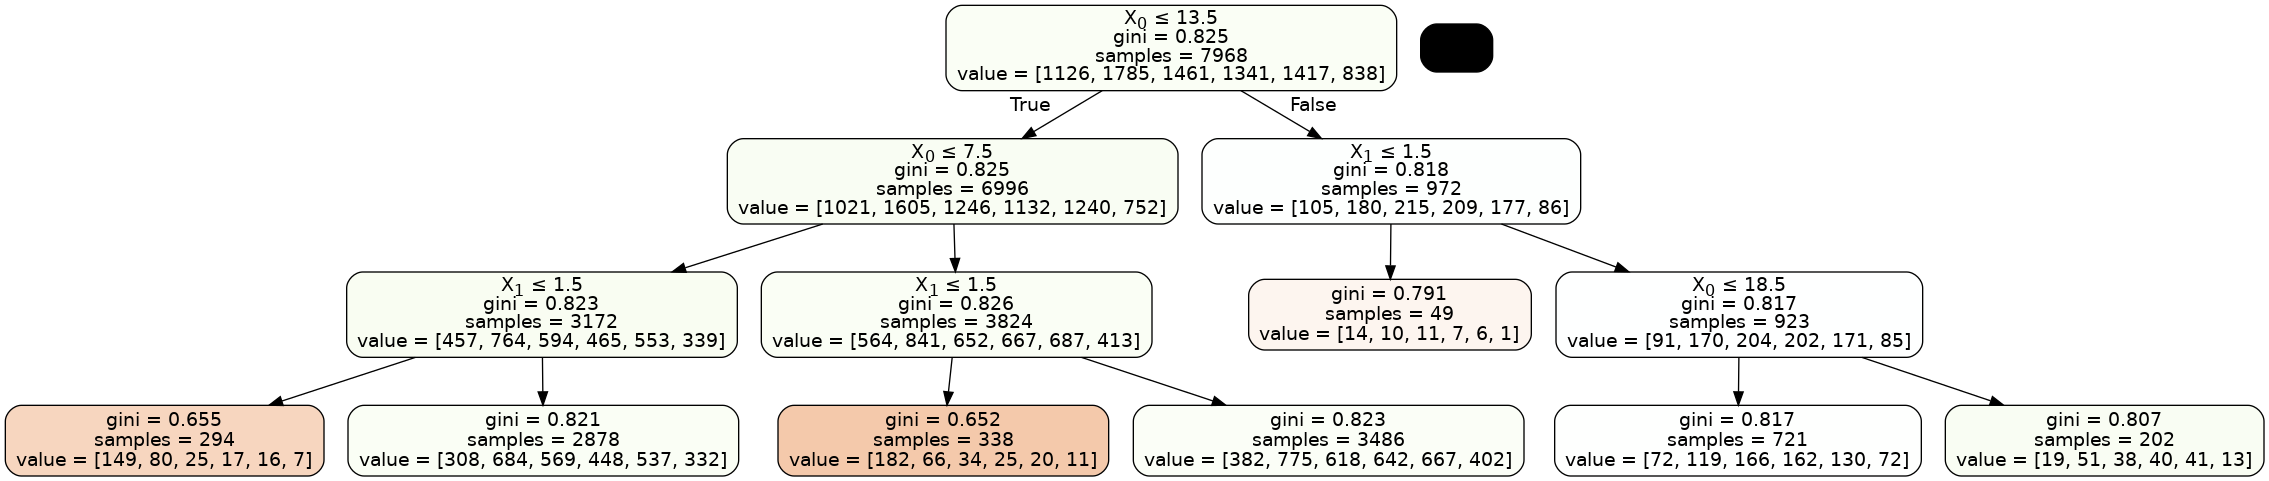

In [30]:
# Display decision tree for the best model 1
utils9.display_tree(best_dt_models[0])

In [31]:
# Get predictions for best model 2 using training data
dt_y_pred_train_2 = best_dt_models[1].predict(dt_x_train)
# Get predictions for best model 2 using validation data
dt_y_pred_val_2 = best_dt_models[1].predict(dt_x_val)

In [32]:
# Display metrics for the best model 2 using training data
print("Metrics for Best Model 2 using Training Data:")
display_metrics(best_dt_models[1], dt_x_train, dt_y_train, dt_y_pred_train_2)

# Display metrics for the best model 2 using validation data
print("\nMetrics for Best Model 2 using Validation Data:")
display_metrics(best_dt_models[1], dt_x_val, dt_y_val, dt_y_pred_val_2)

Metrics for Best Model 2 using Training Data:
Classification Report:
              precision    recall  f1-score   support

           1       0.52      0.31      0.38      1126
           2       0.24      0.73      0.36      1785
           3       0.29      0.16      0.21      1461
           4       0.24      0.18      0.21      1341
           5       0.29      0.02      0.03      1417
           6       0.43      0.00      0.01       838

    accuracy                           0.27      7968
   macro avg       0.33      0.23      0.20      7968
weighted avg       0.32      0.27      0.21      7968


Confusion Matrix:
[[ 344  593   81  100    8    0]
 [ 152 1303  132  183   14    1]
 [  63  969  239  176   12    2]
 [  47  892  146  239   17    0]
 [  38 1028  154  172   24    1]
 [  18  612   82  114    9    3]]

Metrics for Best Model 2 using Validation Data:
Classification Report:
              precision    recall  f1-score   support

           1       0.51      0.34      0.41

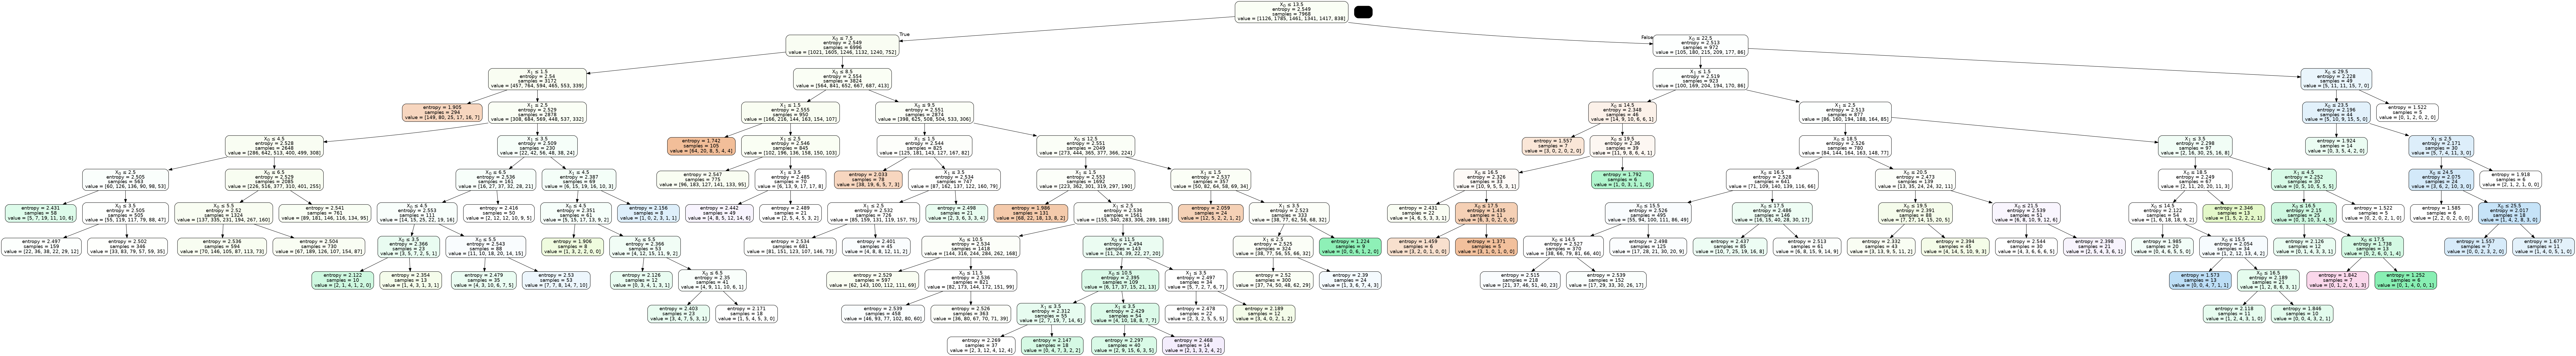

In [33]:
# Display decision tree for the best model 2
utils9.display_tree(best_dt_models[1])

<span style="color:blue;">[2 marks] Select and justify your final choice of hyperparameters based on the training and validation metrics. Provide a written analysis in markdown.</span>

From my analysis, it seems that Model 1, characterized by specific hyperparameters including 'gini' as the criterion, a maximum depth of 3, utilization of the square root of the total number of features as the maximum features, maintaining a minimum impurity decrease of 0.0, and ensuring a minimum samples leaf of 5, emerges as the preferable choice. While both models demonstrated comparable accuracies on both the training and validation datasets, the inherent simplicity of Model 1, particularly its restricted depth, presents a compelling argument in its favor. By opting for Model 1's hyperparameters, there's a distinct advantage in potentially mitigating the risk of overfitting, thus fostering a more robust and balanced performance overall. In my perspective I would recommend adopting the hyperparameters of Model 1 for optimal results.